# 气候观察者模型


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

## 一次运行

In [2]:
from past1000.abm import Model
import matplotlib.pyplot as plt
from hydra import compose, initialize

with initialize(config_path="../config", version_base=None):
    cfg = compose(config_name="config", overrides=["model=test"])

# 运行模型
model = Model(parameters=cfg)
model

环境变量加载: True (文件存在), True (加载成功)


<Model-v0.7.5(init)>

In [3]:
model.run_model()

[16:12:19][WARNING][datacollector] No final reporters have been definedreturning empty DataFrame.


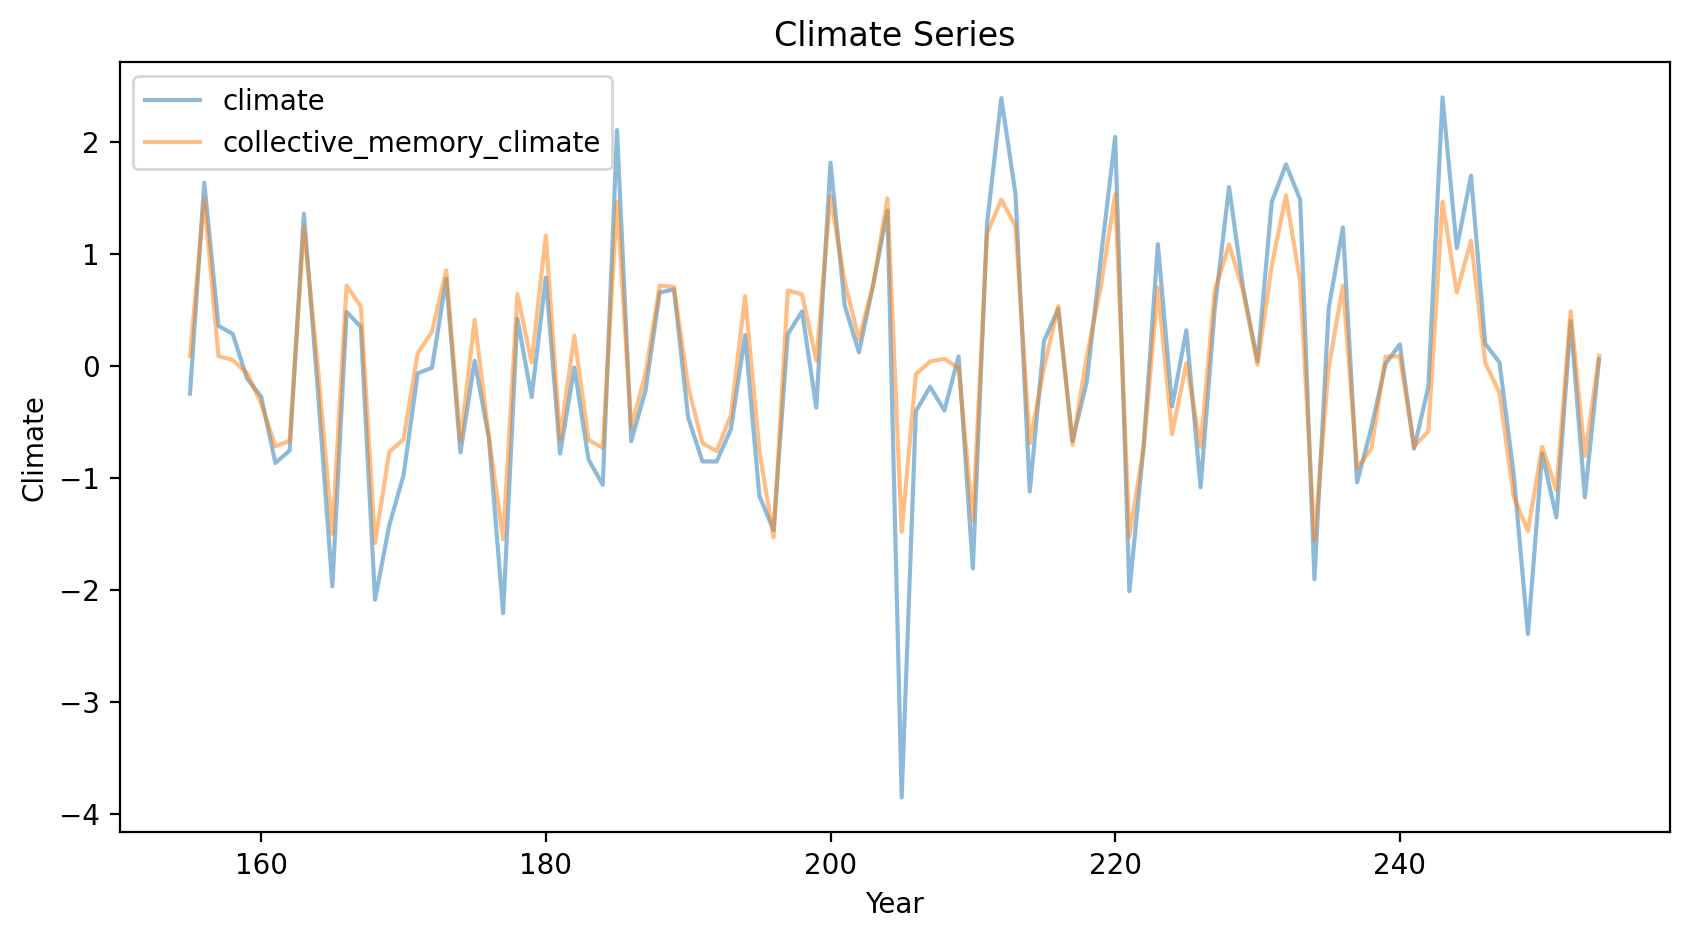

In [4]:
# 绘制气候序列和历史平均
fig, ax = plt.subplots(figsize=(10, 5))
model.stable_df.plot(ax=ax, label="Climate Series", alpha=0.5)
ax.set_title("Climate Series")
ax.set_xlabel("Year")
ax.set_ylabel("Climate")
ax.legend()
plt.show();

MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

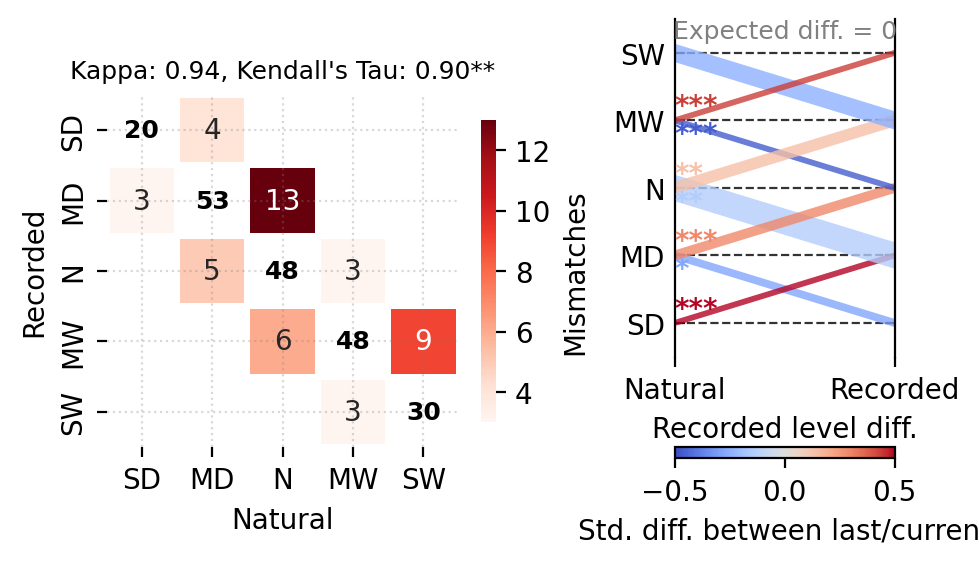

In [5]:
model.mismatch_report.generate_report_figure();

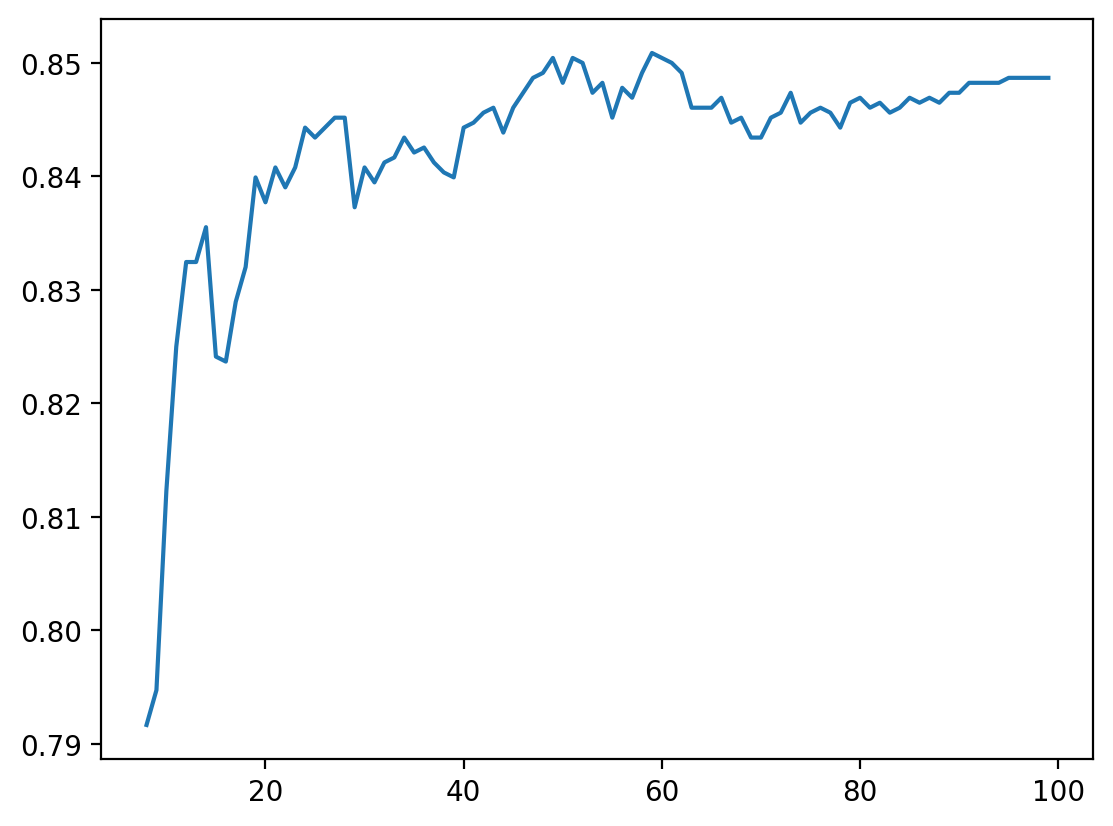

In [7]:
from past1000.compare import compare_corr_2d
from past1000.filters import calc_std_deviation

windows = np.arange(2, 100)
min_periods = np.repeat(cfg.min_period, 98)

rs, ps, ns = compare_corr_2d(
    model.stable_df["collective_memory_climate"],
    model.stable_df["climate"],
    windows=windows,
    min_periods=min_periods,
    filter_func=calc_std_deviation,
    corr_method="kendall",
    filter_side="right",
)
plt.plot(windows, rs);

In [9]:
model.p.rejudge

False

## 读取模型结果

,index,variable,value,run,model,repeats,rejudge
1955,95,model_10,0.869298,1,exp,10,False
1956,96,model_10,0.869298,1,exp,10,False
1957,97,model_10,0.869298,1,exp,10,False
1958,98,model_10,0.869737,1,exp,10,False
1959,99,model_10,0.869737,1,exp,10,False


<Axes: xlabel='index', ylabel='value'>

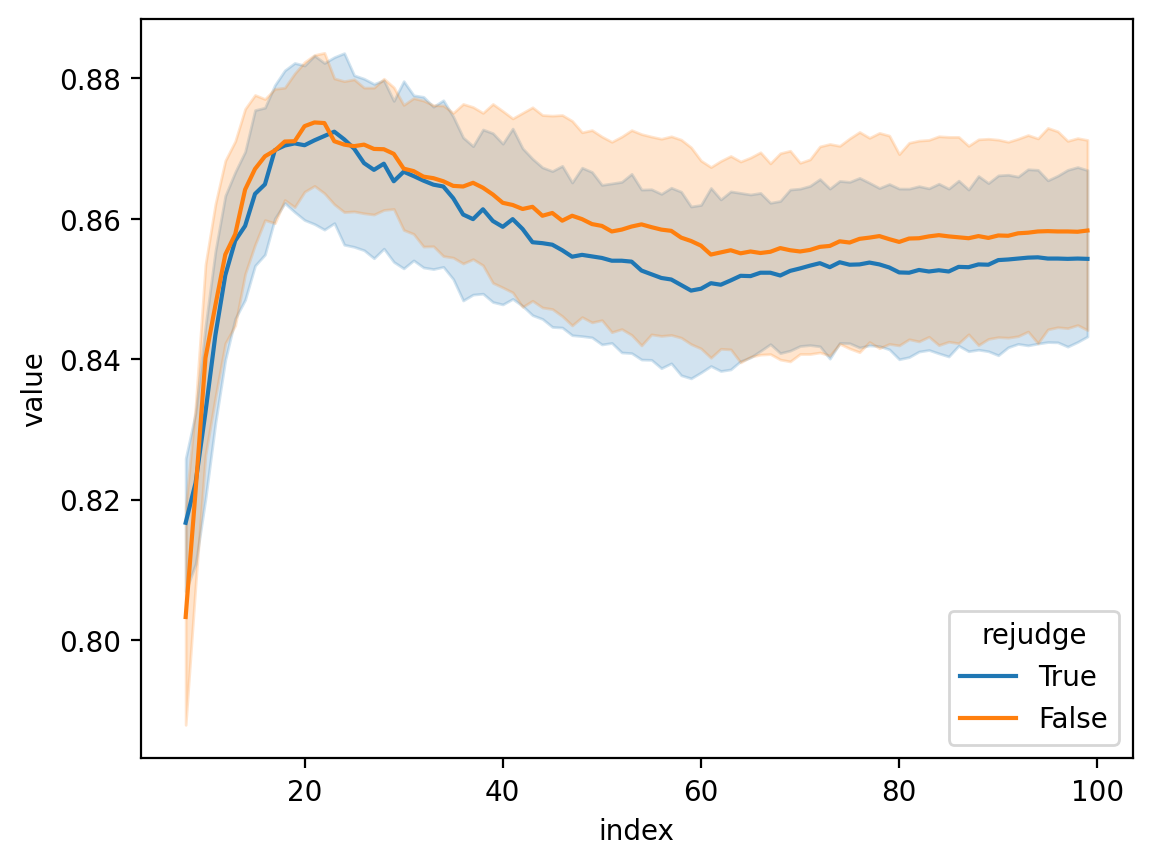

In [13]:
import yaml
from hydra import compose, initialize
import seaborn as sns

with initialize(config_path="../config", version_base=None):
    cfg = compose(config_name="config")

path = Path(cfg.ds.abm)

datasets = []

for subdir in path.iterdir():
    if subdir.is_dir():
        corr_file = subdir / "correlations.csv"
        hydra_config = subdir / ".hydra" / "overrides.yaml"
        if corr_file.exists() and hydra_config.exists():
            # 读取 correlations.csv
            df = pd.read_csv(corr_file, index_col=0)
            long = df.melt(ignore_index=False).reset_index()
            long["run"] = subdir.name

            # 读取 hydra 配置
            with open(hydra_config, "r") as f:
                overrides = yaml.safe_load(f)
            # 解析每个参数
            param_dict = {}
            for item in overrides:
                if "=" in item:
                    key, value = item.split("=", 1)
                    # 只保留 how. 开头的参数（可选）
                    if key.startswith("how."):
                        key = key.replace("how.", "")
                    param_dict[key] = value
            # 将参数字典展开为多列
            for k, v in param_dict.items():
                long[k] = v

            datasets.append(long)

# 合并所有数据
# 去除掉所有表头的 model.
df_all = pd.concat(datasets, ignore_index=True)
for col in df_all.columns:
    try:
        df_all[col] = pd.to_numeric(df_all[col], errors="raise")
    except (ValueError, TypeError):
        pass
    if col.startswith("model."):
        df_all = df_all.rename(columns={col: col.replace("model.", "")})
# 1. 找每个 (rejudge, max_age, run) 下最大 correlation 的 Year
# 假设 df_all 已经有 'max_age', 'rejudge', 'variable', 'index', 'value'
df_all.tail()
sns.lineplot(data=df_all, x="index", y="value", hue="rejudge")

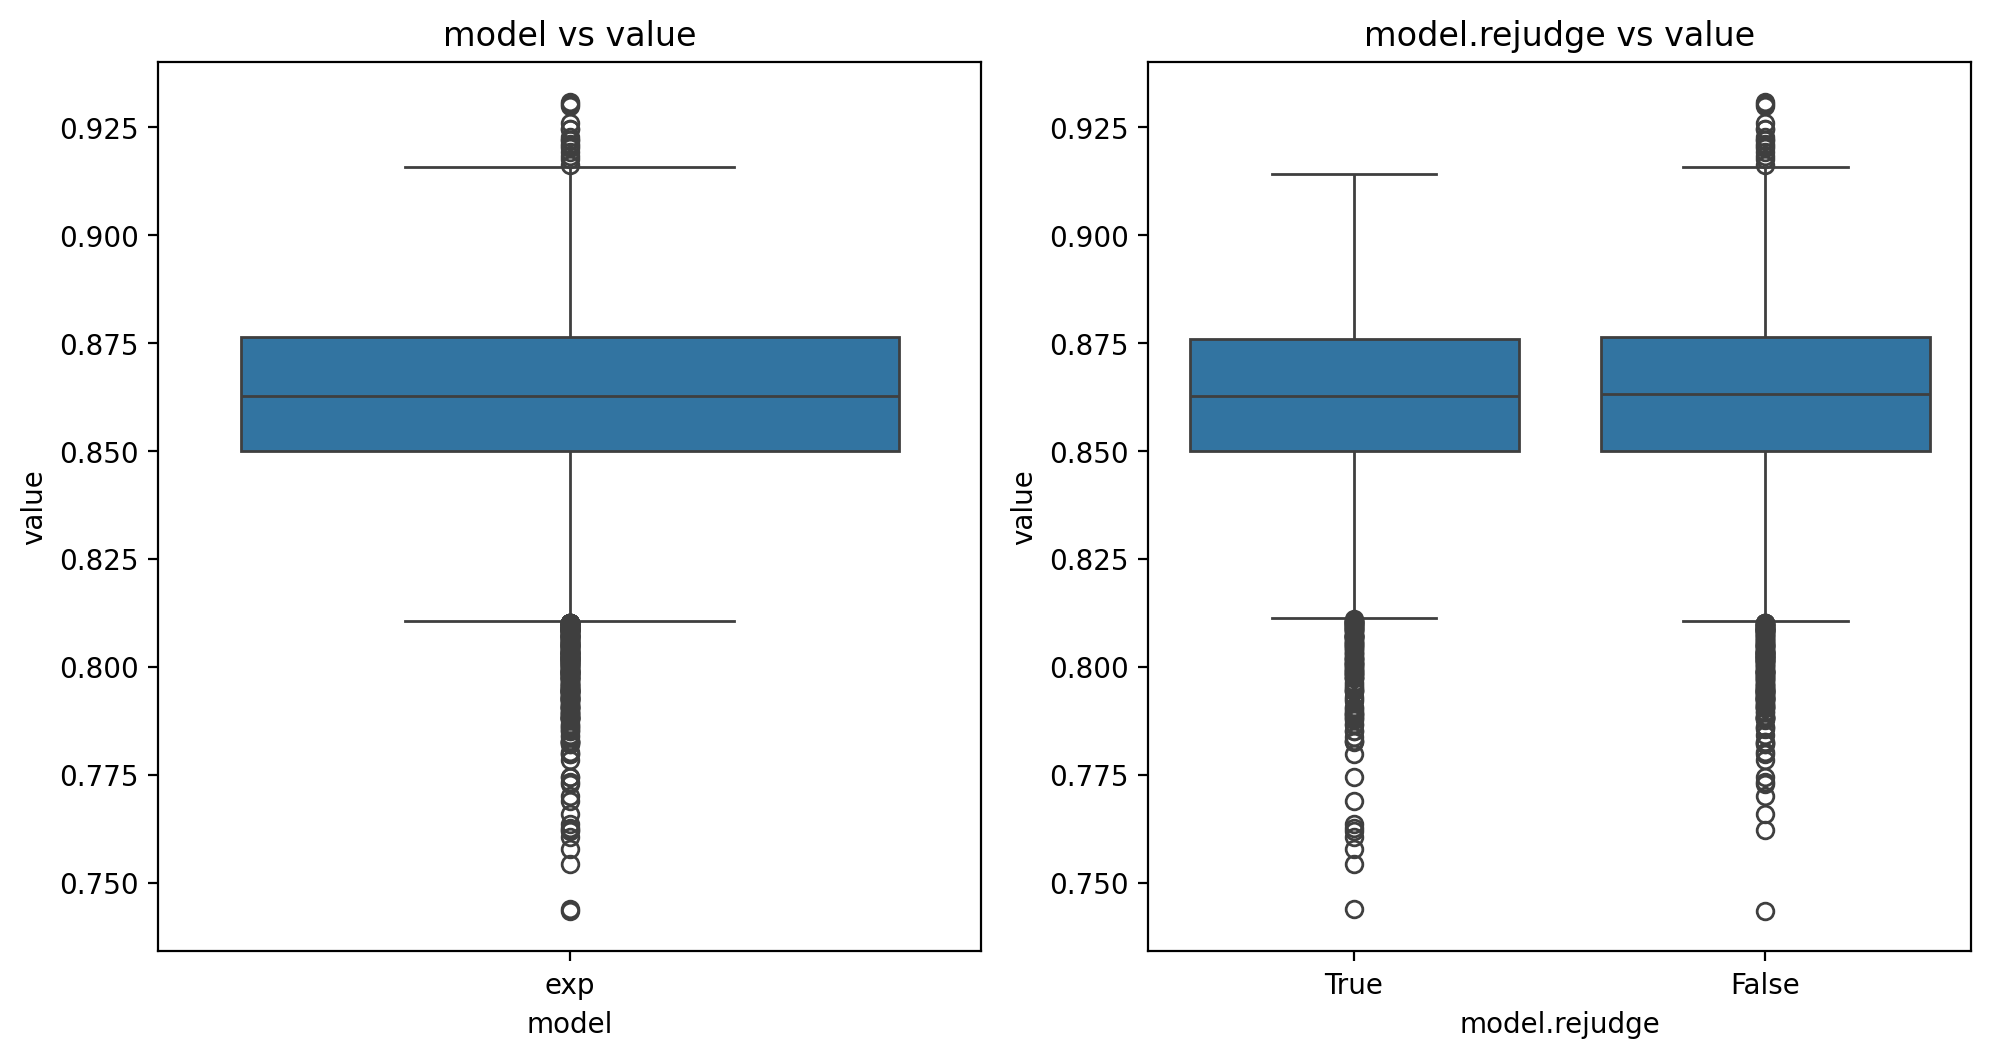

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np

INDEX_COLS = {"index", "variable", "value", "run", "how"}


def single_factor_sensitivity(df, target_col="value", params=None):
    """
    单因子敏感性分析：一次只变化一个参数

    Args:
        df: 数据框
        target_col: 目标变量列名

    Returns:
        sensitivity_results: 敏感性分析结果
    """
    from scipy import stats

    if params is None:
        params = list(set(df.columns.tolist()) - INDEX_COLS)
    results = {}

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, param in enumerate(params):
        ax = axes[i]

        if df[param].dtype == "object" or df[param].nunique() < 10:
            # 分类变量：箱线图
            sns.boxplot(data=df, x=param, y=target_col, ax=ax)
            ax.set_title(f"{param} vs {target_col}")

            # 方差分析
            groups = [group[target_col].values for name, group in df.groupby(param)]
            f_stat, p_value = stats.f_oneway(*groups)
            results[param] = {
                "type": "categorical",
                "f_statistic": f_stat,
                "p_value": p_value,
                "effect_size": "eta_squared",  # 需要计算
            }

        else:
            # 连续变量：散点图和相关性
            ax.scatter(df[param], df[target_col], alpha=0.6)
            ax.set_xlabel(param)
            ax.set_ylabel(target_col)
            ax.set_title(f"{param} vs {target_col}")

            # 添加趋势线
            z = np.polyfit(df[param], df[target_col], 1)
            p = np.poly1d(z)
            ax.plot(df[param], p(df[param]), "r--", alpha=0.8)

            # 相关性分析
            pearson_r, pearson_p = pearsonr(df[param], df[target_col])
            spearman_r, spearman_p = spearmanr(df[param], df[target_col])

            results[param] = {
                "type": "continuous",
                "pearson_r": pearson_r,
                "pearson_p": pearson_p,
                "spearman_r": spearman_r,
                "spearman_p": spearman_p,
            }

            # 在图上显示相关系数
            ax.text(
                0.05,
                0.95,
                f"r={pearson_r:.3f}\np={pearson_p:.3f}",
                transform=ax.transAxes,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
            )

    # 移除多余的子图
    if len(params) < len(axes):
        for j in range(len(params), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return results


# 运行单因子分析
single_results = single_factor_sensitivity(df_all)

In [6]:
def multi_factor_anova(
    df,
    target_col="value",
    categorical_params=None,
    continuous_params=None,
) -> dict:
    """
    多因子方差分析，评估参数的主效应和交互效应

    Args:
        df: 数据框
        target_col: 目标变量

    Returns:
        anova_results: ANOVA分析结果
    """
    from statsmodels.stats.anova import anova_lm
    from statsmodels.formula.api import ols

    # 准备数据：确保分类变量是字符串类型
    df_anova = df.copy()
    if categorical_params is None:
        categorical_params = ["rejudge"]
    for param in categorical_params:
        df_anova[param] = df_anova[param].astype(str)

    # 构建模型公式
    if continuous_params is None:
        continuous_params = ["max_age", "min_age", "loss_rate", "new_agents"]
    all_params = categorical_params + continuous_params

    # 主效应模型
    main_formula = f"{target_col} ~ " + " + ".join(all_params)

    # 包含二阶交互效应的模型
    interaction_formula = f"{target_col} ~ (" + " + ".join(all_params) + ")**2"

    print("=== 主效应ANOVA ===")
    main_model = ols(main_formula, data=df_anova).fit()
    main_anova = anova_lm(main_model, typ=2)
    print(main_anova)

    print("\n=== 包含交互效应的ANOVA ===")
    interaction_model = ols(interaction_formula, data=df_anova).fit()
    interaction_anova = anova_lm(interaction_model, typ=2)
    print(interaction_anova)

    # 计算效应大小 (Eta squared)
    def calculate_eta_squared(anova_table):
        anova_table["eta_sq"] = anova_table["sum_sq"] / anova_table["sum_sq"].sum()
        return anova_table

    main_anova_with_eta = calculate_eta_squared(main_anova)
    interaction_anova_with_eta = calculate_eta_squared(interaction_anova)

    return {
        "main_effects": main_anova_with_eta,
        "with_interactions": interaction_anova_with_eta,
        "main_model": main_model,
        "interaction_model": interaction_model,
    }


# 运行多因子ANOVA
anova_results = multi_factor_anova(df_all)

KeyError: 'rejudge'

In [20]:
def find_max_correlation_by_all_params(
    df, target_col="value", time_col="index", exclude_cols=None
):
    """
    根据所有参数列分组，找到每组目标变量达到最大值的时间点

    Args:
        df: 数据框
        target_col: 目标变量列名（默认'value'）
        time_col: 时间列名（默认'index'）
        exclude_cols: 需要排除的列名列表（可选）

    Returns:
        DataFrame: 每组最大值对应的时间点和参数信息
    """
    if "min_age" in df.columns:
        df["max_length"] = df["max_age"].astype(int) - df["min_age"].astype(int)
        df = df[df["max_length"] > 0]
    elif "max_age" in df.columns:
        df["max_length"] = df["max_age"]
    else:
        pass
    # 默认排除的列
    default_exclude = {"index", "variable", "value", "run", "how", "max_age", "min_age"}

    if exclude_cols is not None:
        exclude_cols = set(exclude_cols)
        exclude_cols.update(default_exclude)
    else:
        exclude_cols = default_exclude

    # 自动识别参数列
    all_cols = set(df.columns)
    param_cols = list(all_cols - exclude_cols)

    print(f"使用的分组参数: {param_cols}")
    print(f"排除的列: {sorted(exclude_cols)}")

    # 定义分组函数
    def get_max_info(group):
        max_idx = group[target_col].idxmax()
        max_row = group.loc[max_idx]
        return pd.Series(
            {
                "max_year": max_row[time_col],
                "max_value": max_row[target_col],
                "group_size": len(group),
            }
        )

    # 执行分组和聚合
    result = (
        df.groupby(param_cols, dropna=False)
        .apply(get_max_info, include_groups=False)
        .reset_index()
    )

    # 重命名列以更清晰
    result = result.rename(
        columns={
            "max_year": f"Year_of_Max_{target_col}",
            "max_value": f"Max_{target_col}",
        }
    )

    return result


# 使用函数
max_points_comprehensive = find_max_correlation_by_all_params(df_all)
print(f"\n总共找到 {len(max_points_comprehensive)} 个参数组合")
max_points_comprehensive.head(10)

使用的分组参数: ['model', 'max_length', 'rejudge']
排除的列: ['how', 'index', 'max_age', 'min_age', 'run', 'value', 'variable']

总共找到 12 个参数组合


,model,max_length,rejudge,Year_of_Max_value,Max_value,group_size
0,exp,25,False,15.0,0.903947,9800.0
1,exp,25,True,18.0,0.902632,9800.0
2,exp,30,False,18.0,0.907895,9800.0
3,exp,30,True,16.0,0.908772,9800.0
4,exp,35,False,18.0,0.914912,9800.0
5,exp,35,True,20.0,0.908333,9800.0
6,exp,40,False,23.0,0.910526,9800.0
7,exp,40,True,19.0,0.917544,9800.0
8,exp,45,False,30.0,0.923246,9800.0
9,exp,45,True,36.0,0.912281,9800.0


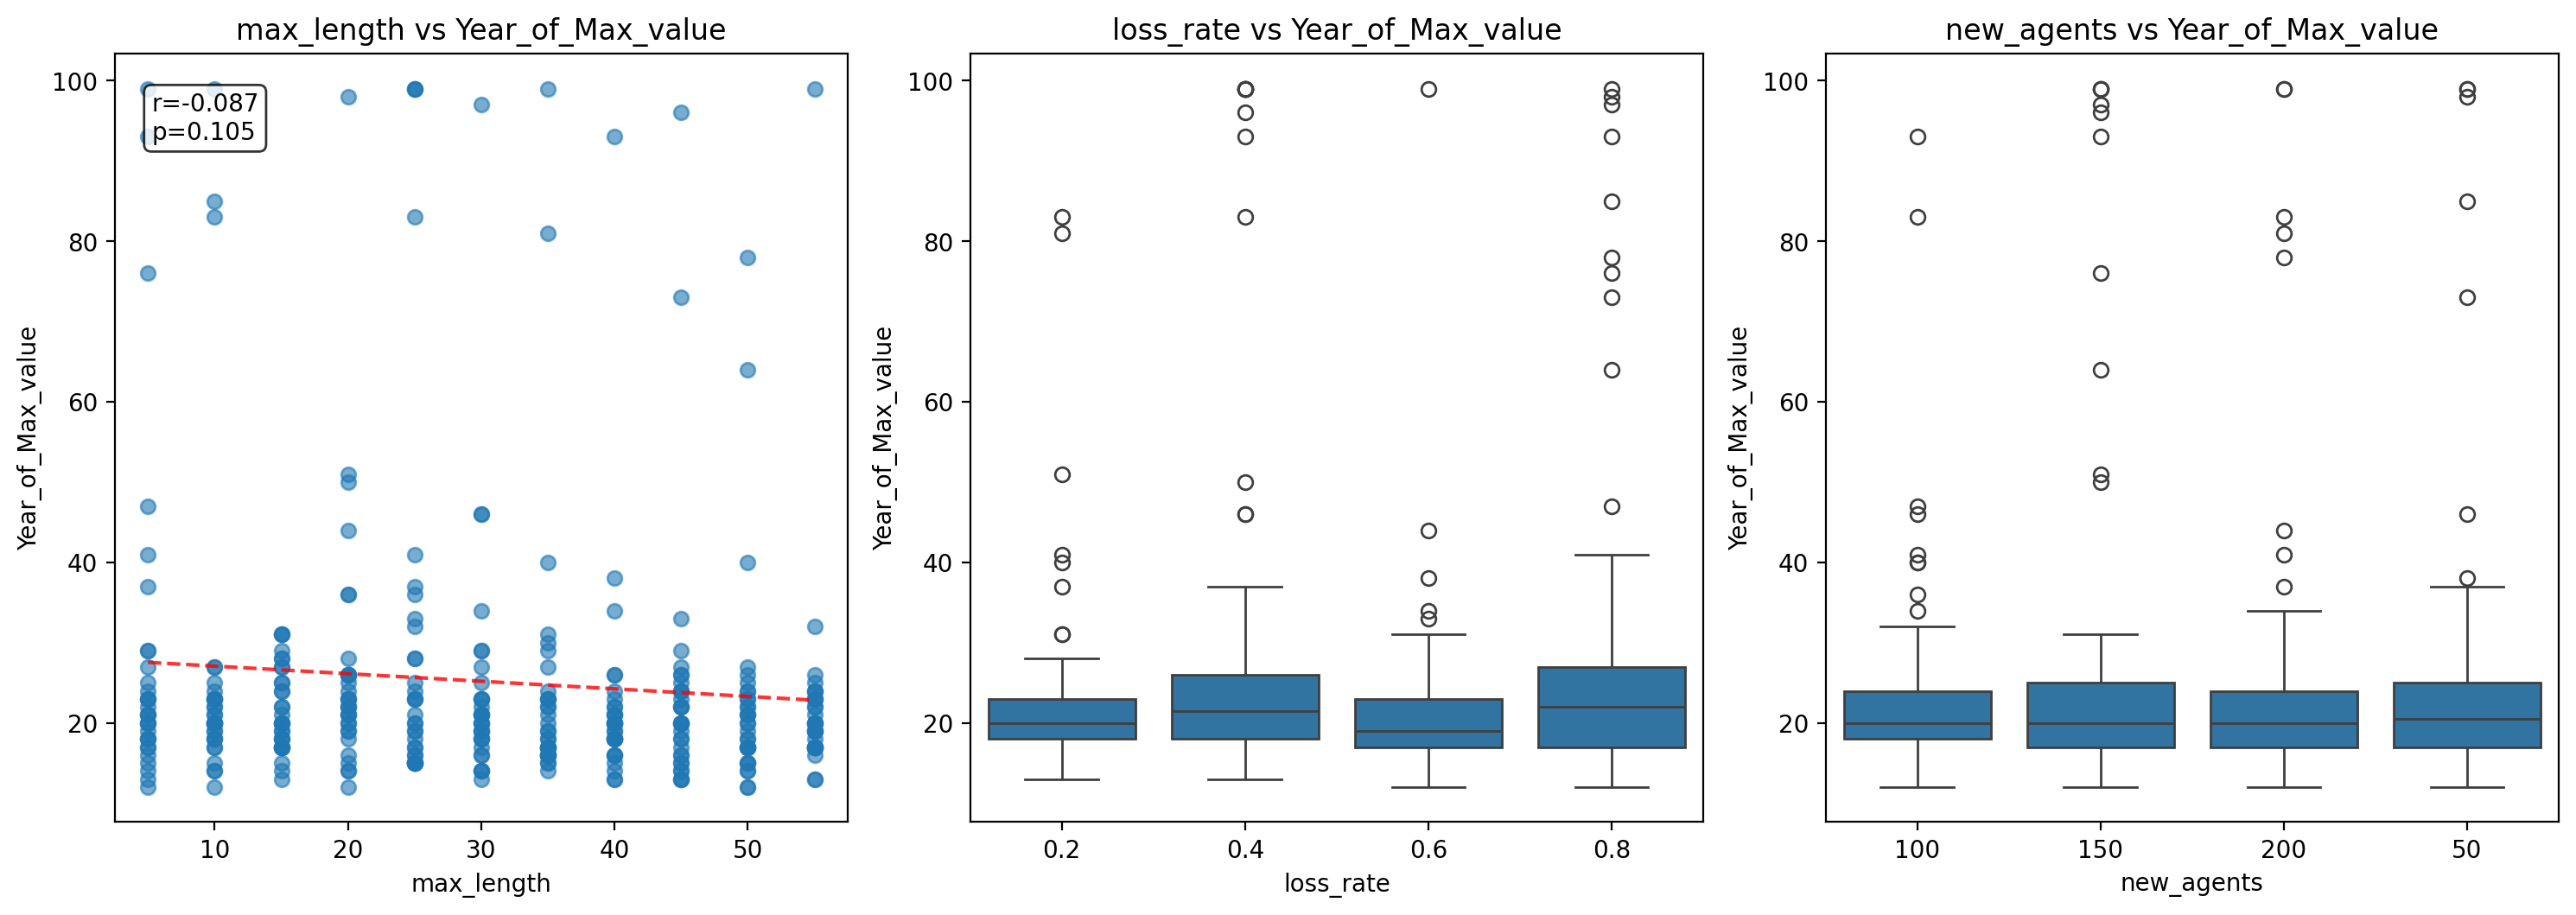

{'max_length': {'type': 'continuous',
  'pearson_r': -0.08665425205377894,
  'pearson_p': 0.10457885767354243,
  'spearman_r': -0.11137639820993178,
  'spearman_p': 0.03673687054312417},
 'loss_rate': {'type': 'categorical',
  'f_statistic': 4.695250624470158,
  'p_value': 0.003149022758907604,
  'effect_size': 'eta_squared'},
 'new_agents': {'type': 'categorical',
  'f_statistic': 0.6723424478745561,
  'p_value': 0.5694875846439318,
  'effect_size': 'eta_squared'}}

In [48]:
single_factor_sensitivity(
    max_points_comprehensive,
    target_col="Year_of_Max_value",
    params=["max_length", "loss_rate", "new_agents"],
)

In [49]:
multi_factor_anova(
    max_points_comprehensive,
    target_col="Year_of_Max_value",
    categorical_params=["rejudge"],
    continuous_params=["max_length", "loss_rate", "new_agents"],
)

=== 主效应ANOVA ===
                  sum_sq     df         F    PR(>F)
rejudge       690.480114    1.0  2.413615  0.121207
loss_rate    4055.667614    3.0  4.725610  0.003028
new_agents    600.781250    3.0  0.700022  0.552578
max_length    782.840909    1.0  2.736467  0.098996
Residual    98124.477273  343.0       NaN       NaN

=== 包含交互效应的ANOVA ===
                             sum_sq     df         F    PR(>F)
rejudge                  690.480114    1.0  2.450106  0.118502
loss_rate               4055.667614    3.0  4.797057  0.002773
new_agents               600.781250    3.0  0.710606  0.546254
rejudge:loss_rate       2256.303977    3.0  2.668764  0.047687
rejudge:new_agents      1812.917614    3.0  2.144325  0.094548
loss_rate:new_agents    2923.025568    9.0  1.152455  0.325303
max_length               782.840909    1.0  2.777840  0.096552
rejudge:max_length        20.404545    1.0  0.072404  0.788042
max_length:loss_rate     432.354545    3.0  0.511390  0.674699
max_length:new_agen

{'main_effects':                   sum_sq     df         F    PR(>F)    eta_sq
 rejudge       690.480114    1.0  2.413615  0.121207  0.006623
 loss_rate    4055.667614    3.0  4.725610  0.003028  0.038902
 new_agents    600.781250    3.0  0.700022  0.552578  0.005763
 max_length    782.840909    1.0  2.736467  0.098996  0.007509
 Residual    98124.477273  343.0       NaN       NaN  0.941204,
 'with_interactions':                              sum_sq     df         F    PR(>F)    eta_sq
 rejudge                  690.480114    1.0  2.450106  0.118502  0.006623
 loss_rate               4055.667614    3.0  4.797057  0.002773  0.038902
 new_agents               600.781250    3.0  0.710606  0.546254  0.005763
 rejudge:loss_rate       2256.303977    3.0  2.668764  0.047687  0.021642
 rejudge:new_agents      1812.917614    3.0  2.144325  0.094548  0.017389
 loss_rate:new_agents    2923.025568    9.0  1.152455  0.325303  0.028037
 max_length               782.840909    1.0  2.777840  0.096552  0

array(['0.2', '0.4', '0.6', '0.8'], dtype=object)

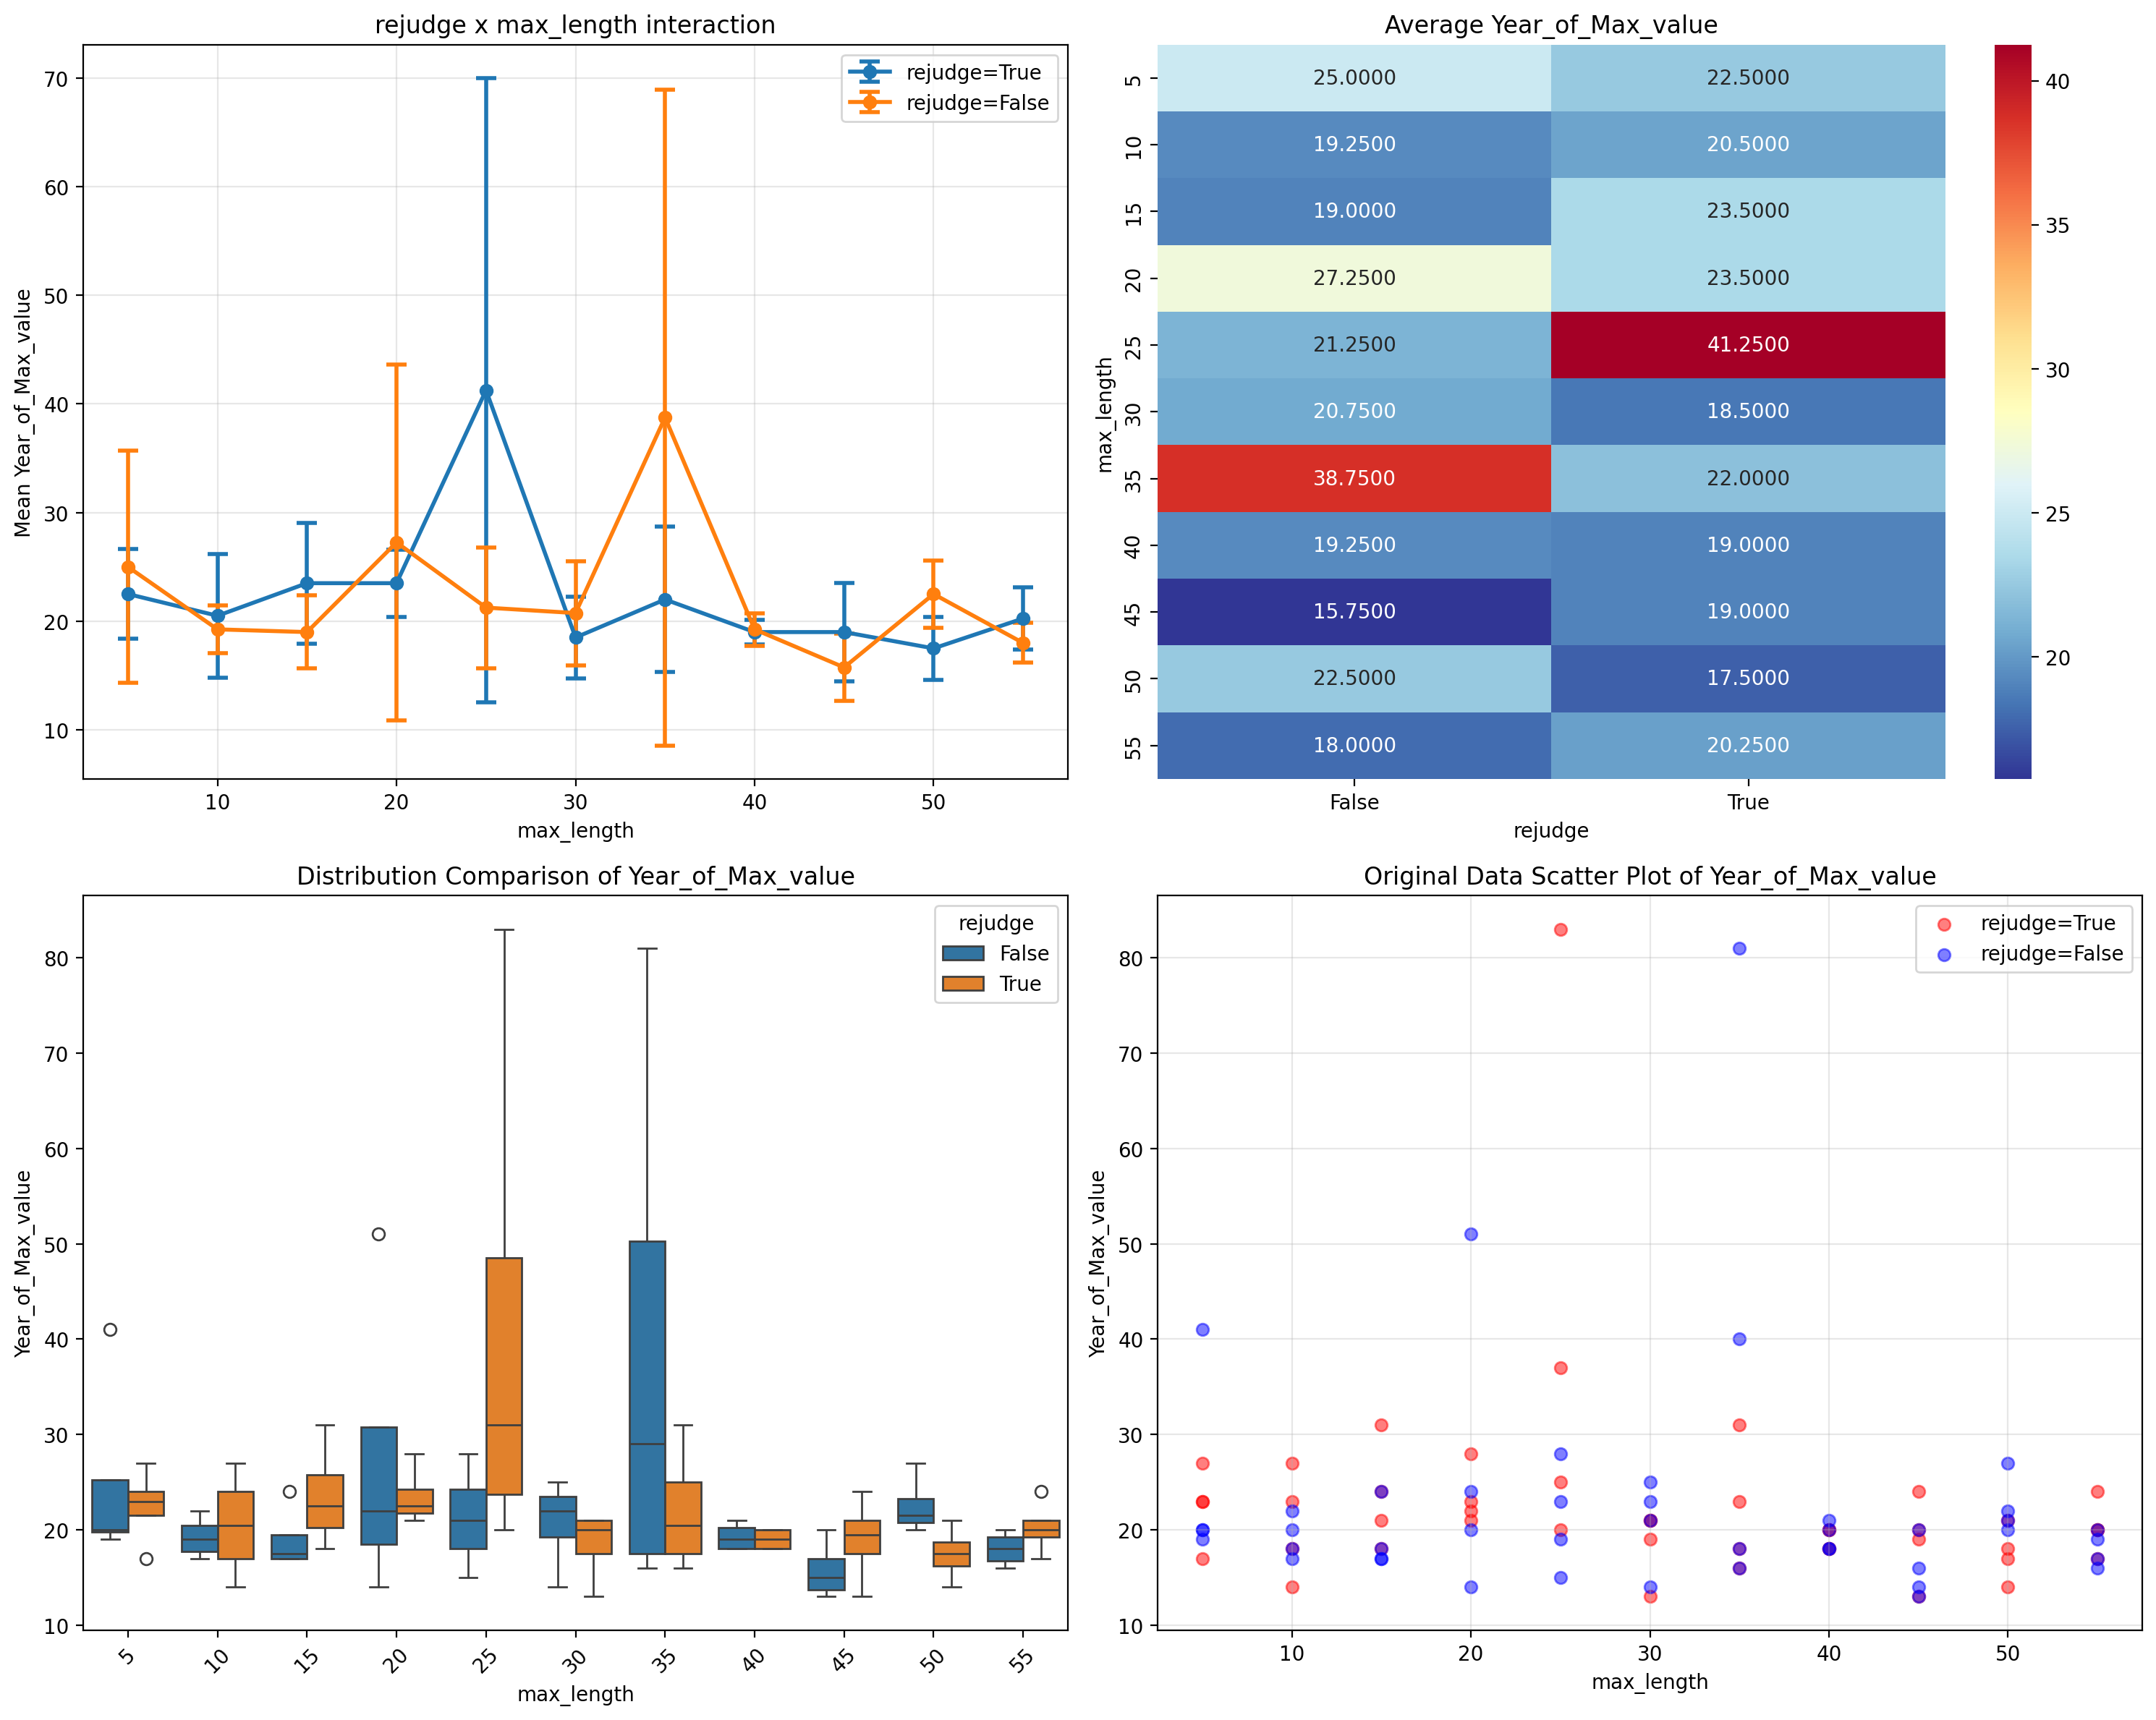

In [50]:
def plot_rejudge_maxage_interaction(
    df, target_col="value", cate="rejudge", cont="max_age"
):
    """
    绘制 rejudge 和 max_age 的交互效应图

    Args:
        df: 数据框
        target_col: 目标变量列名
    """
    # 确保rejudge是字符串类型
    df = df.copy()
    df[cate] = df[cate].astype(str)

    # 创建多种交互图
    _, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. 线图：显示交互效应
    ax1 = axes[0, 0]
    # 计算每个组合的均值
    interaction_data = (
        df.groupby([cont, cate])[target_col].agg(["mean", "std", "count"]).reset_index()
    )

    for rejudge_val in ["True", "False"]:
        subset = interaction_data[interaction_data["rejudge"] == rejudge_val]
        ax1.errorbar(
            subset[cont],
            subset["mean"],
            yerr=subset["std"],
            marker="o",
            capsize=5,
            capthick=2,
            linewidth=2,
            label=f"rejudge={rejudge_val}",
        )

    ax1.set_xlabel(cont)
    ax1.set_ylabel(f"Mean {target_col}")
    ax1.set_title(f"{cate} x {cont} interaction")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. 热图：显示均值分布
    ax2 = axes[0, 1]
    pivot_data = df.pivot_table(
        values=target_col, index=cont, columns=cate, aggfunc="mean"
    )
    sns.heatmap(pivot_data, annot=True, fmt=".4f", cmap="RdYlBu_r", ax=ax2)
    ax2.set_title(f"Average {target_col}")

    # 3. 箱线图：显示分布差异
    ax3 = axes[1, 0]
    sns.boxplot(data=df, x=cont, y=target_col, hue=cate, ax=ax3)
    ax3.set_title(f"Distribution Comparison of {target_col}")
    ax3.tick_params(axis="x", rotation=45)

    # 4. 散点图：显示原始数据
    ax4 = axes[1, 1]
    for rejudge_val, color in zip(["True", "False"], ["red", "blue"]):
        subset = df[df["rejudge"] == rejudge_val]
        ax4.scatter(
            subset[cont],
            subset[target_col],
            alpha=0.5,
            color=color,
            label=f"{cate}={rejudge_val}",
        )

    ax4.set_xlabel(cont)
    ax4.set_ylabel(target_col)
    ax4.set_title(f"Original Data Scatter Plot of {target_col}")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# 绘制交互图
max_points_comprehensive.loss_rate.unique()
subset = max_points_comprehensive[max_points_comprehensive["loss_rate"] == "0.2"]
plot_rejudge_maxage_interaction(
    subset, target_col="Year_of_Max_value", cate="rejudge", cont="max_length"
)

### Max Age 作图

In [52]:
max_points_comprehensive.head()

,new_agents,rejudge,max_length,loss_rate,Year_of_Max_value,Max_value,group_size
0,100,False,5,0.2,20.0,0.769135,196.0
1,100,False,5,0.4,20.0,0.703160,196.0
2,100,False,5,0.6,12.0,0.677833,196.0
3,100,False,5,0.8,47.0,0.763661,196.0
4,100,False,10,0.2,18.0,0.720084,294.0


<Axes: title={'center': 'Year of Max Correlation vs Max Length'}, xlabel='Max age of the observers', ylabel='Year of Max Correlation'>

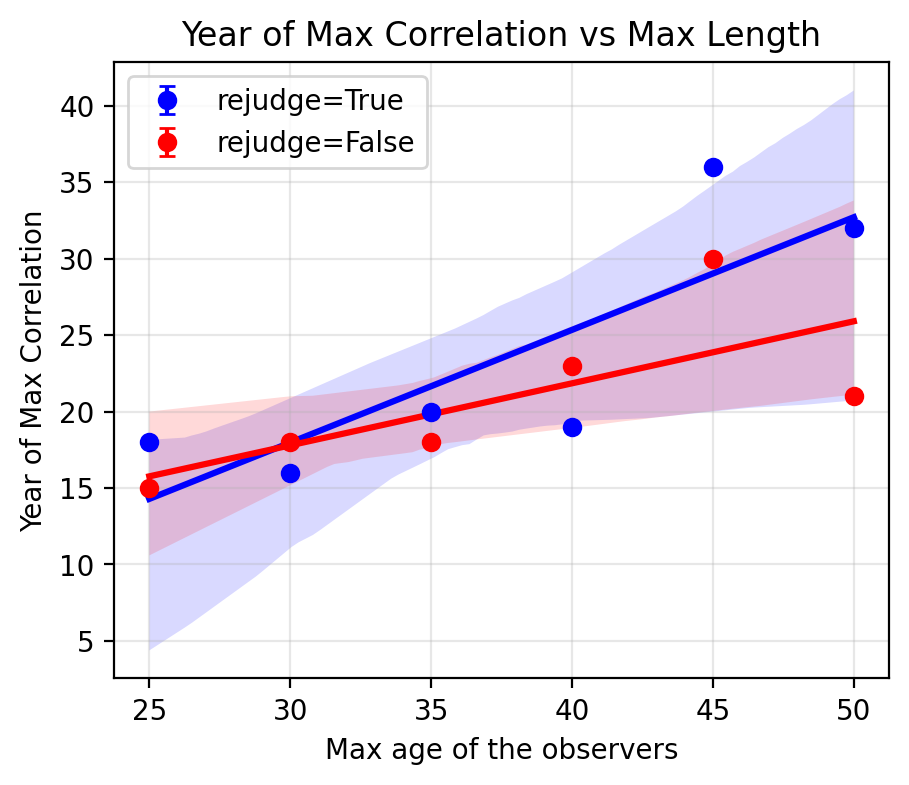

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product


def plot_maxlength_maxcorr_year(
    max_years,
    x_axis_col="max_length",
    y_axis_col="Year_of_Max_value",
):
    """Test"""
    plt.figure(figsize=(5, 4))
    ax = plt.gca()

    # 使用 scatterplot + errorbar 替代 pointplot
    for rejudge_val, color in zip(["True", "False"], ["blue", "red"]):
        subset = max_years[max_years["rejudge"] == rejudge_val]

        # 计算每个 max_age 的均值和标准差
        stats = (
            subset.groupby("max_length")[y_axis_col].agg(["mean", "std"]).reset_index()
        )

        # 绘制错误棒
        ax.errorbar(
            stats["max_length"],
            stats["mean"],
            yerr=stats["std"],
            fmt="o",
            color=color,
            capsize=3,
            label=f"rejudge={rejudge_val}",
        )

        # 添加回归线
        sns.regplot(
            data=subset,
            x="max_length",
            y=y_axis_col,
            scatter=False,
            color=color,
            ax=ax,
        )

    ax.set_ylabel("Year of Max Correlation")
    ax.set_xlabel("Max age of the observers")
    ax.set_title("Year of Max Correlation vs Max Length")
    ax.legend()
    ax.grid(True, alpha=0.3)
    return ax


plot_maxlength_maxcorr_year(max_points_comprehensive)
# for new_agents_now, loss_rate_now in product(
#     max_points_comprehensive["new_agents"].unique(),
#     max_points_comprehensive["loss_rate"].unique(),
# ):
#     new_agents = max_points_comprehensive["new_agents"] == new_agents_now
#     loss_rate = max_points_comprehensive["loss_rate"] == loss_rate_now
#     ax = plot_maxlength_maxcorr_year(max_points_comprehensive[new_agents & loss_rate])
#     ax.set_title(f"new_agents={new_agents_now}, loss_rate={loss_rate_now}")
#     plt.show();